In [1]:
import sys  
sys.path.insert(0, '../autocbh/')
import numpy as np
import pandas as pd
import networkx as nx
from calcCBH import calcCBH
import matplotlib.pyplot as plt
from CBH import buildCBH

In [2]:
c = calcCBH()
c.calc_Hf()
rem_ls = list(set([s for s in c.energies.index.to_list() if 'CBH' in c.energies.loc[s, "source"]]))
dfs = c.generate_CBH_coeffs(rem_ls, allow_overshoot=True, include_target=False)
dfs_f = c.generate_CBH_coeffs(rem_ls, 9, allow_overshoot=True, include_target=False)
cbh_lvl = {s : int(c.energies.loc[s, 'source'][4]) for s in rem_ls}

Process completed with errors in 1 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


In [102]:
#%% Function to make position dicts by partition
def make_node_positions(graph, partition_attr, layout_func, partition_order=None, epsilon=1):
    """
    https://stackoverflow.com/questions/64923687/
    """
    if not partition_order:
        # get a list of all the partition names if not specified
        partition_order = list(set(dict(graph.nodes(data=partition_attr)).values()))
        
    # make position dict for each partition
    orig_partition_pos_dicts = {partition:layout_func(graph.subgraph([node for node,part in graph.nodes(data=partition_attr)
                                                                                      if part == partition]))
                                for partition in partition_order}
    
    # update the x coordinate in the position dicts so partitions
    # don't overlap and are in the specified order left-to-right
    final_pos_dict = orig_partition_pos_dicts[partition_order[0]]
    for i,partition in enumerate(partition_order[1:]):
        # get the largest x coordinate from the previous partition's nodes
        max_previous = max([x for x,y in final_pos_dict.values()])
        # get smallest x coordinate from this partition's nodes
        current_min = min([x for x,y in orig_partition_pos_dicts[partition].values()])
        # update the x coordinates for this partition to be at least epsilon units
        # to the right of the right-most node in the previous partition
        final_pos_dict.update({node:(pos[0]+max_previous+abs(current_min)+epsilon,pos[1])
                                               for node,pos in orig_partition_pos_dicts[partition].items()})
    return(final_pos_dict)

In [105]:
c.energies.loc[:, 'source']

F                                                                            ATcT
O                                                                            ATcT
[H][H]                                                                       ATcT
C                                                                            ATcT
CF                                                                           ATcT
CO                                                                           ATcT
FC(F)F                                                                       ATcT
OC(F)F                                                                       ATcT
CC                                                                           ATcT
COC                                                                          ATcT
FC(F)(F)F                                                                    ATcT
OC(F)(F)F                                                           CBH-1-H//anl0
CC(=O)O         

In [10]:
dict_of_list = {}
for s in rem_ls:
    dfs_s = dfs[cbh_lvl[s]].loc[s]
    
    ls = [dfs_s.index.to_list()[i] for i, t in enumerate(dfs_s.values != 0) if t == True]
    
    if 'avg' in c.energies.loc[s, 'source']:
        dfs_f_s = dfs_f[cbh_lvl[s]].loc[s]
        ls += [dfs_f_s.index.to_list()[i] for i, t in enumerate(dfs_f_s.values != 0) if t == True]
        
    dict_of_list[s] = list(set(ls))
    
G = nx.Graph(dict_of_list)

rank_attr = {}
color_attr = {}
rung_attr = {}
for node in G.nodes:
    source = c.energies.loc[node, 'source']
    if 'CBH' in source:
        rank = c.rankings_rev[source.split('//')[1].split('+')[0]]
        rung_attr[node] = str(cbh_lvl[node])
    else:
        rank = c.rankings_rev[source]
        rung_attr[node] = 'exp'
        
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    color_attr[node] = colors[rank-1]
    rank_attr[node] = rank
    
nx.set_node_attributes(G, rank_attr, 'rank')
nx.set_node_attributes(G, color_attr, 'color')
nx.set_node_attributes(G, rung_attr, 'rung')

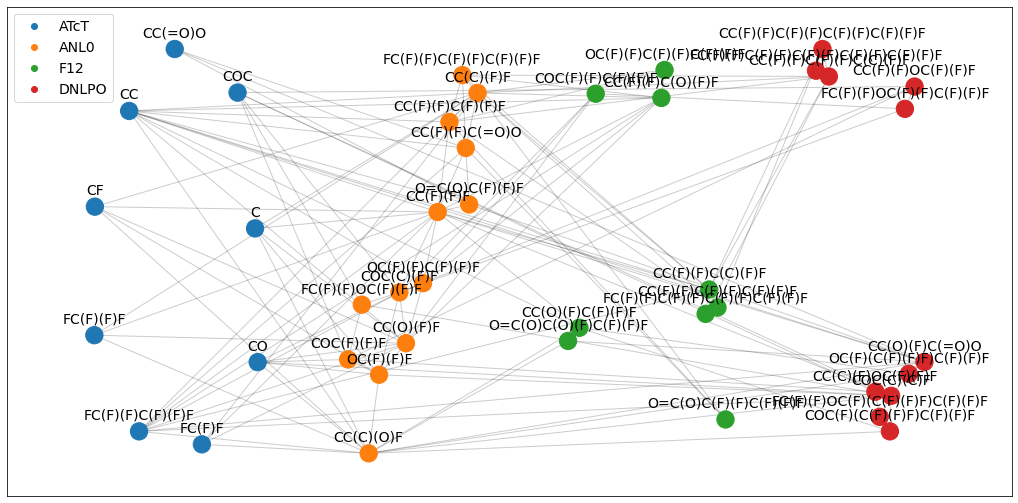

In [29]:
f = plt.figure(figsize=(18,9))
# f = plt.figure(figsize=(18,9), dpi=300)
my_pos = make_node_positions(G, 'rank', nx.springlayout, [1,2,3,4])
# my_pos = make_node_positions(G, 'rung', ['exp', '1', '2', '3', '4', '5'])
nx.draw_networkx_nodes(G, my_pos, node_color=[c for n,c in G.nodes(data='color')])
# nx.draw_networkx_labels(G, my_pos, verticalalignment='top')
nx.draw_networkx_edges(G, my_pos, alpha=0.2)

pos_attrs = {}
for node, coords in my_pos.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)

nx.draw_networkx_labels(G, pos_attrs, font_size=14)

for i in range(4):
    plt.scatter([], [], label=['ATcT', 'ANL0', 'F12', 'DNLPO'][i])
plt.legend(prop={'size': 14})
# plt.savefig('../../../../Job Applications/AbbVie Interview Presentation/figures/thermochemical_network.png', format='png')
plt.show()

In [103]:
f = plt.figure(figsize=(50,20), dpi=300)
pos = nx.multipartite_layout(G, 'rung', align='vertical', scale=0.2)
pos = make_node_positions(G, 'rung', nx.planar_layout, ['exp', '1', '2', '3', '4', '5'])
# nx.draw_networkx(G, pos=pos, node_color=[c for n,c in G.nodes(data='color')])
nx.draw_networkx_nodes(G, pos, node_color=[c for n,c in G.nodes(data='color')], node_size=2000)
nx.draw_networkx_edges(G, pos, alpha=0.2)

pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.04)
nx.draw_networkx_labels(G, pos_attrs, font_size=32)
plt.axis('off')
for i in range(4):
    plt.scatter([], [], label=['ATcT', 'ANL0', 'F12', 'DNLPO'][i], s=1000)
plt.legend(prop={'size': 32}, loc='upper left')
# plt.savefig('../../../../Job Applications/AbbVie Interview Presentation/figures/thermochemical_network_rung.png')

plt.show()